# Project 5 OpenClassroom
Brazilian E-Commerce Public Dataset by Olist
Welcome! This is a Brazilian ecommerce public dataset of orders made at Olist Store. The dataset has information of 100k orders from 2016 to 2018 made at multiple marketplaces in Brazil. Its features allows viewing an order from multiple dimensions: from order status, price, payment and freight performance to customer location, product attributes and finally reviews written by customers. We also released a geolocation dataset that relates Brazilian zip codes to lat/lng coordinates.

This is real commercial data, it has been anonymised, and references to the companies and partners in the review text have been replaced with the names of Game of Thrones great houses.

In [1]:
## To display the graphs within the code and not in another windows 
import sys
print("Python Version :"+str(sys.version_info))
%matplotlib inline
#To be able to use CSV
import csv
print("CSV Version :"+csv.__version__)
# To be able to use Numpy
import numpy as np
print("Numpy Version :"+np.__version__)
# To be able to use Pandas
import pandas as pd
print("Pandas Version :"+pd.__version__)
# To be able to use Maplotlib
import matplotlib.pyplot as plt

# To be able to use Seaborn
import seaborn as sns
print("Seaborn Version :"+sns.__version__)

# To be able to use Warning
import warnings

import string

import datetime as dt
import timeit
import time

import plotly.graph_objects as go
import plotly.express as pex
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import pairwise_distances_argmin

Python Version :sys.version_info(major=3, minor=7, micro=6, releaselevel='final', serial=0)
CSV Version :1.0
Numpy Version :1.18.1
Pandas Version :1.0.1
Seaborn Version :0.10.0


### Init of the main variables

In [2]:
# Disable the warnings 'ignore'
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
# Load Pep8 checker
%load_ext pycodestyle_magic
%pycodestyle_on


In [3]:
smartdata = pd.read_csv('./SmartData.csv', sep=",", header=0)

In [4]:
smartdata

,number_of_orders,total_price,total_freight,total_payment,first_order_date,last_order_date,recency,time_to_deliver,error_between_estimated_and_delivery_date,product_category_name_agro_industry_and_commerce,product_category_name_air_conditioning,product_category_name_art,product_category_name_arts_and_craftmanship,product_category_name_audio,product_category_name_auto,product_category_name_baby,product_category_name_bed_bath_table,product_category_name_books_general_interest,product_category_name_books_imported,product_category_name_books_technical,product_category_name_cds_dvds_musicals,product_category_name_christmas_supplies,product_category_name_cine_photo,product_category_name_computers,product_category_name_computers_accessories,product_category_name_consoles_games,product_category_name_construction_tools_construction,product_category_name_construction_tools_lights,product_category_name_construction_tools_safety,product_category_name_cool_stuff,product_category_name_costruction_tools_garden,product_category_name_costruction_tools_tools,product_category_name_diapers_and_hygiene,product_category_name_drinks,product_category_name_dvds_blu_ray,product_category_name_electronics,product_category_name_fashio_female_clothing,product_category_name_fashion_bags_accessories,product_category_name_fashion_childrens_clothes,product_category_name_fashion_male_clothing,product_category_name_fashion_shoes,product_category_name_fashion_sport,product_category_name_fashion_underwear_beach,product_category_name_fixed_telephony,product_category_name_flowers,product_category_name_food,product_category_name_food_drink,product_category_name_furniture_bedroom,product_category_name_furniture_decor,product_category_name_furniture_living_room,product_category_name_furniture_mattress_and_upholstery,product_category_name_garden_tools,product_category_name_health_beauty,product_category_name_home_appliances,product_category_name_home_appliances_2,product_category_name_home_comfort_2,product_category_name_home_confort,product_category_name_home_construction,product_category_name_housewares,product_category_name_industry_commerce_and_business,product_category_name_kitchen_dining_laundry_garden_furniture,product_category_name_la_cuisine,product_category_name_luggage_accessories,product_category_name_market_place,product_category_name_music,product_category_name_musical_instruments,product_category_name_office_furniture,product_category_name_others,product_category_name_party_supplies,product_category_name_pc_gamer,product_category_name_perfumery,product_category_name_pet_shop,product_category_name_security_and_services,product_category_name_signaling_and_security,product_category_name_small_appliances,product_category_name_small_appliances_home_oven_and_coffee,product_category_name_sports_leisure,product_category_name_stationery,product_category_name_tablets_printing_image,product_category_name_telephony,product_category_name_toys,product_category_name_watches_gifts,product_category_name_nan,product_main_category_name_Convenience Products,product_main_category_name_Shopping Products,product_main_category_name_Speciality Products,product_main_category_name_Unsought Products,product_main_category_name_nan,customer_state_AC,customer_state_AL,customer_state_AM,customer_state_AP,customer_state_BA,customer_state_CE,customer_state_DF,customer_state_ES,customer_state_GO,customer_state_MA,customer_state_MG,customer_state_MS,customer_state_MT,customer_state_PA,customer_state_PB,customer_state_PE,customer_state_PI,customer_state_PR,customer_state_RJ,customer_state_RN,customer_state_RO,customer_state_RR,customer_state_RS,customer_state_SC,customer_state_SE,customer_state_SP,customer_state_TO,customer_state_nan,review_score_1.0,review_score_2.0,review_score_3.0,review_score_4.0,review_score_5.0,review_score_nan,payment_type_boleto,payment_type_credit_card,payment_type_debit_card,payment_type_voucher,payment_type_nan,R,F,M,RFM_Segment_Concat,RFM_Score,RFM_Level
0,1,129.

In [5]:
columns_name_dict = {"number_of_orders": "Frequency", "recency": "Recency"}
columns_name_dict["total_payment"] = "Monetary"
smartdata = smartdata.rename(columns=columns_name_dict)

In [6]:
RFM_df = smartdata[['Recency', 'Frequency', 'Monetary']]

### DBScan

###### Limit the analysis to the first 1000 lines 

In [7]:
r_df = RFM_df.iloc[0:1000]

In [8]:
restrictedX = r_df.values.astype("float32", copy=False)

###### Data standardisation

In [9]:
restrictedX = StandardScaler().fit_transform(restrictedX)

In [10]:
restrictedX_df = pd.DataFrame(restrictedX)
restrictedX_df.columns = ['Recency', 'Frequency', 'Monetary']
print(restrictedX_df.head())

    Recency  Frequency  Monetary
0 -0.827793   -0.32226 -0.167764
1 -0.808036   -0.32226 -0.439696
2  1.977772   -0.32226 -0.299759
3  0.555232   -0.32226 -0.400747
4  0.337899   -0.32226 -0.037405


###### DBScan algorithm

In [11]:
# #############################################################################
# Compute DBSCAN
db = DBSCAN(eps=0.7, min_samples=9, n_jobs=-1).fit(restrictedX_df)
labels = db.labels_
core_samples = np.zeros_like(labels, dtype=bool)
core_samples[db.core_sample_indices_] = True

###### Results of DBScan

In [12]:
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(restrictedX, labels))

Estimated number of clusters: 3
Estimated number of noise points: 49
Silhouette Coefficient: 0.347


In [13]:
# Building the label to colour mapping
mylabels = {}
mylabels[0] = 'Not convinced'
mylabels[1] = 'Promising'
mylabels[2] = 'Regular'
mylabels[-1] = 'Unlabelled'

# Building the colour vector for each data point
listoflabels = [mylabels[label] for label in labels]

In [14]:
r_df['Label'] = listoflabels

### Display 3 2D Graphs

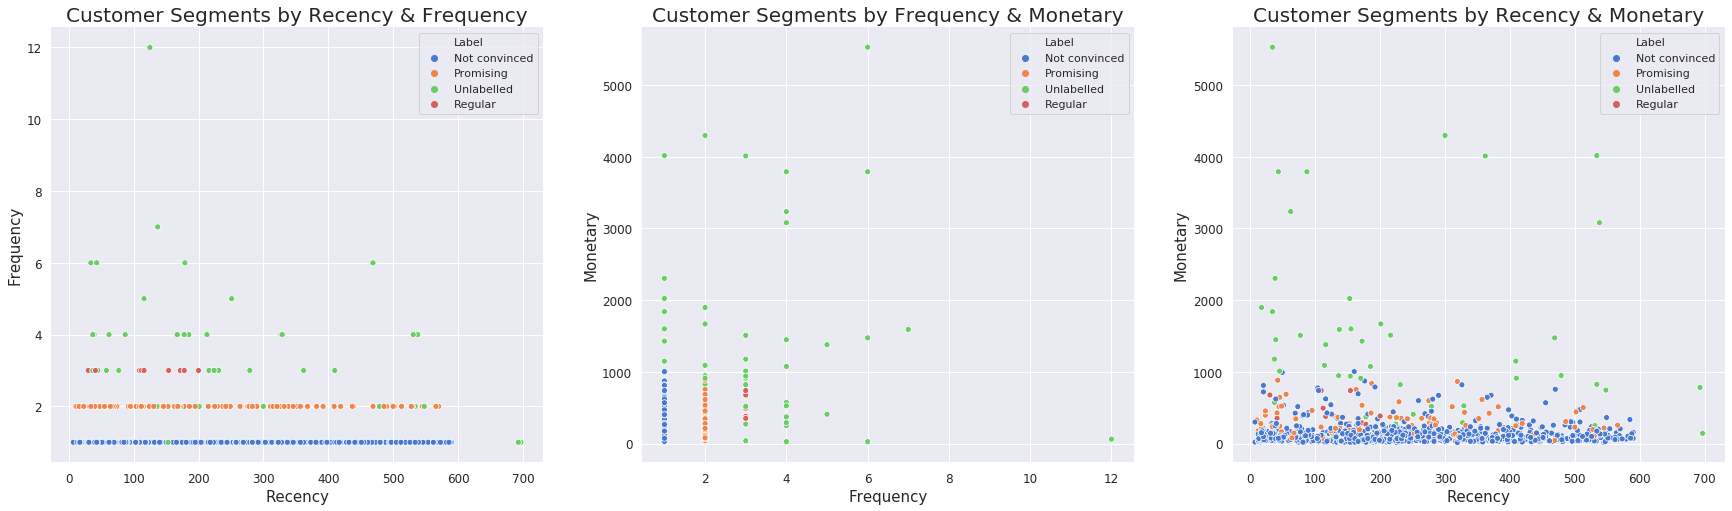

In [31]:
# plotting the distribution of the continous feature set
sns.set(palette='muted', color_codes=True, style='darkgrid')
fig, axs = plt.subplots(1, 3, figsize=(30, 8))
sns.despine(left=True)
sns.scatterplot(x='Recency', y='Frequency', ax=axs[0], hue='Label', data=r_df)
sns.scatterplot(x='Frequency', y='Monetary', ax=axs[1], hue='Label', data=r_df)
sns.scatterplot(x='Recency', y='Monetary', ax=axs[2], hue='Label', data=r_df)


axs[0].set_title('Customer Segments by Recency & Frequency', fontsize=20)
axs[0].set_xlabel("Recency", fontsize=15)
axs[0].set_ylabel("Frequency", fontsize=15)
axs[0].tick_params(labelsize=12)
axs[1].set_title('Customer Segments by Frequency & Monetary', fontsize=20)
axs[1].set_xlabel("Frequency", fontsize=15)
axs[1].set_ylabel("Monetary", fontsize=15)
axs[1].tick_params(labelsize=12)
axs[2].set_title('Customer Segments by Recency & Monetary', fontsize=20)
axs[2].set_xlabel("Recency", fontsize=15)
axs[2].set_ylabel("Monetary", fontsize=15)
axs[2].tick_params(labelsize=12)

fig.savefig('RFMDBScan.png')

From here, we can see that the main clusters are:

Notconvinced - clients that only purchased one time on the web site 

Promising - clients that purchased two time on the web site 

Regular - clients that often purchase on the web site 


### Kmeans

In [16]:
X = RFM_df.values.astype("float32", copy=False)
X = StandardScaler().fit_transform(X)
X_df = pd.DataFrame(X)
X_df.columns = ['Recency', 'Frequency', 'Monetary']
print(X_df.head())

    Recency  Frequency  Monetary
0 -0.828863  -0.282176 -0.109995
1 -0.809202  -0.282176 -0.287500
2  1.962985  -0.282176 -0.196155
3  0.547400  -0.282176 -0.262075
4  0.331130  -0.282176 -0.024902


Training time: 0.638
For n_clusters = 2 The silhouette_score is : 0.4387698
Training time: 1.274
For n_clusters = 3 The silhouette_score is : 0.4693014
Training time: 1.562
For n_clusters = 4 The silhouette_score is : 0.4789542
Training time: 2.098
For n_clusters = 5 The silhouette_score is : 0.48148397
Training time: 1.597
For n_clusters = 6 The silhouette_score is : 0.4873468
Training time: 2.043
For n_clusters = 7 The silhouette_score is : 0.42076346
Training time: 3.757
For n_clusters = 8 The silhouette_score is : 0.4529428


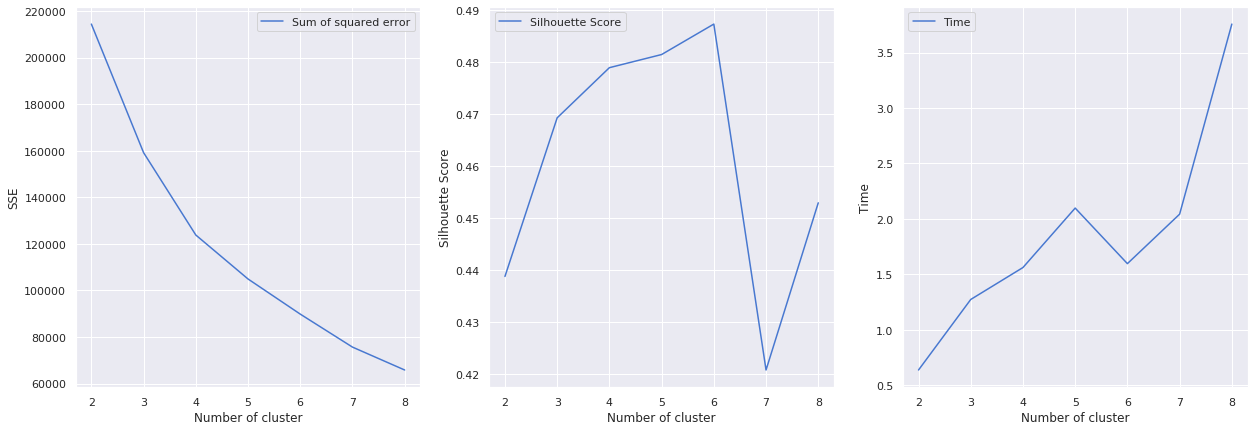

In [17]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
elbow = []
ss = []
time_list = []
for n_clusters in range_n_clusters:
    # iterating through cluster sizes
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    t0 = time.time()
    # t=timeit.Timer("mylr.fit(myX_train,myy_train)", globals=globals())
    cluster_labels = clusterer.fit_predict(X_df)
    time_one = round(time.time()-t0, 3)
    print("Training time:", time_one)
    time_list.append(time_one)
    # Finding the average silhouette score
    s_avg = metrics.silhouette_score(X_df, cluster_labels)
    ss.append(s_avg)
    print("For n_clusters =", n_clusters, "The silhouette_score is :", s_avg)
    # Finding the average SSE
    elbow.append(clusterer.inertia_)
fig = plt.figure(figsize=(21, 7))
fig.add_subplot(131)
plt.plot(range_n_clusters, elbow, 'b-', label='Sum of squared error')
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.legend()
fig.add_subplot(132)
plt.plot(range_n_clusters, ss, 'b-', label='Silhouette Score')
plt.xlabel("Number of cluster")
plt.ylabel("Silhouette Score")
plt.legend()
fig.add_subplot(133)
plt.plot(range_n_clusters, time_list, 'b-', label='Time')
plt.xlabel("Number of cluster")
plt.ylabel("Time")
plt.legend()
plt.show()
fig.savefig('MetricsClusterKMeans.png')

The best number of clusters is 4 because of the highest silhouette score and of the elbow.

###### Analysis of the stability of the centroids.

In [18]:
t_batch = time.time()
clusterer = KMeans(n_clusters=4, random_state=42)
clusterer.fit(X_df)
k_means_centers = clusterer.cluster_centers_
k_means_cluster_labels = pairwise_distances_argmin(X_df, k_means_centers)

In [19]:
print(k_means_centers)

[[ 9.8247063e-01 -1.3763571e-01 -6.6337846e-02]
 [-9.9317851e-03  1.5811072e+01  3.8666447e+01]
 [-7.2042352e-01 -1.4753182e-01 -6.7260265e-02]
 [-4.5436617e-02  3.3528752e+00  1.3625351e+00]]


In [20]:
print(k_means_cluster_labels)

[2 2 0 ... 0 2 0]


In [21]:
k_array = np.empty(shape=[0, 3])
number_of_clusters = 4
states_list = [1, 5, 10, 15, 20]
for count in states_list:
    clusterer = KMeans(n_clusters=number_of_clusters, random_state=count)
    clusterer.fit(X_df)
    k_array = np.concatenate((k_array, clusterer.cluster_centers_))

c_df = pd.DataFrame(data=k_array, columns=["Recency", "Frequency", "Monetary"])
labels_list = list()
for count in range(1, number_of_clusters+1):
    labels_list.append("Label "+str(count))
rounds_list = list()
for count in range(1, len(states_list)+1):
    rounds_list.append("Round "+str(count))

c_df['Label'] = np.tile(labels_list, len(c_df)//len(labels_list))
cendroids_idx = pd.Index(rounds_list)
c_df['Round'] = cendroids_idx.repeat(number_of_clusters)

In [22]:
c_df

,Recency,Frequency,Monetary,Label,Round
0,0.982471,-0.137636,-0.066338,Label 1,Round 1
1,-0.720424,-0.147532,-0.067260,Label 2,Round 1
2,-0.009932,15.811072,38.666447,Label 3,Round 1
3,-0.045437,3.352875,1.362535,Label 4,Round 1
4,-0.045437,3.352875,1.362535,Label 1,Round 2
5,0.982471,-0.137636,-0.066338,Label 2,Round 2
6,-0.720424,-0.147532,-0.067260,Label 3,Round 2
7,-0.009932,15.811072,38.666447,Label 4,Round 2
8,0.982471,-0.137636,-0.066338,Label 1,Round 3
9,-0.045437,3.352875,1.362535,Label 2,Round 3


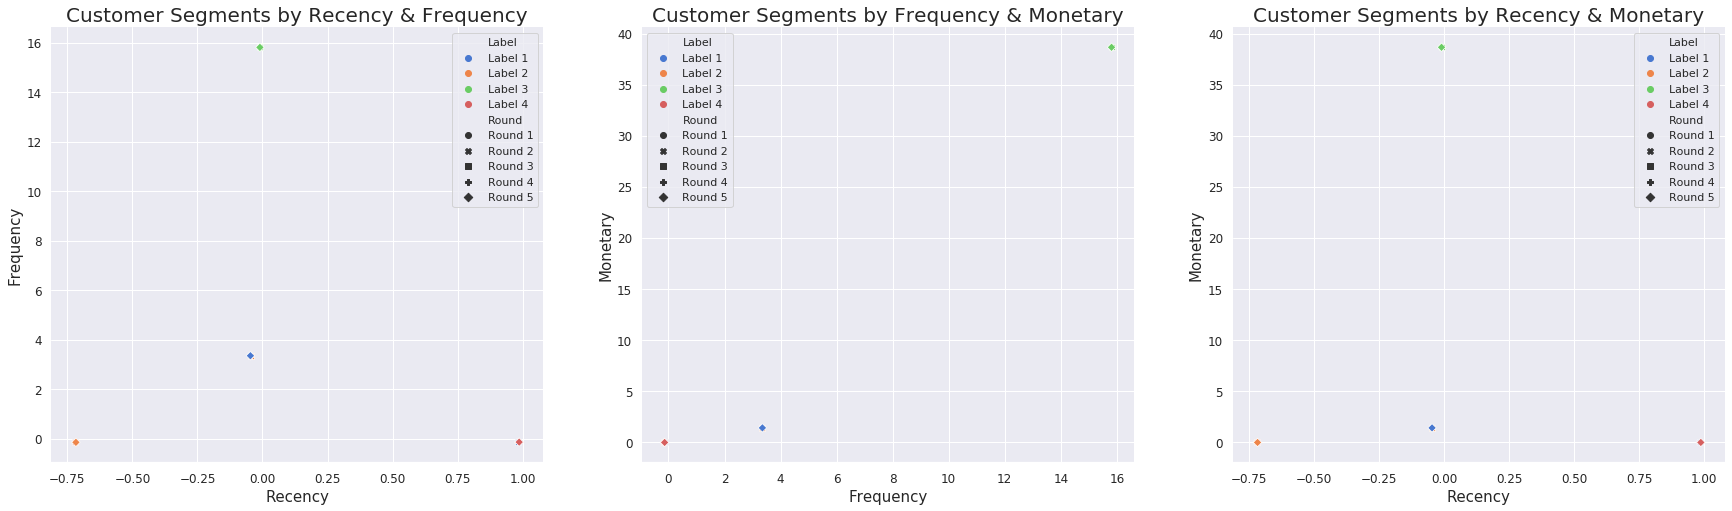

In [23]:
# plotting the distribution of the continous feature set
sns.set(palette='muted', color_codes=True, style='darkgrid')
fig, axs = plt.subplots(1, 3, figsize=(30, 8))
sns.despine(left=True)
sns.scatterplot(x='Recency', y='Frequency', ax=axs[0], hue='Label', style='Round', data=c_df)
sns.scatterplot(x='Frequency', y='Monetary', ax=axs[1], hue='Label', style='Round', data=c_df)
sns.scatterplot(x='Recency', y='Monetary', ax=axs[2], hue='Label', style='Round', data=c_df)


axs[0].set_title('Customer Segments by Recency & Frequency', fontsize=20)
axs[0].set_xlabel("Recency", fontsize=15)
axs[0].set_ylabel("Frequency", fontsize=15)
axs[0].tick_params(labelsize=12)
axs[1].set_title('Customer Segments by Frequency & Monetary', fontsize=20)
axs[1].set_xlabel("Frequency", fontsize=15)
axs[1].set_ylabel("Monetary", fontsize=15)
axs[1].tick_params(labelsize=12)
axs[2].set_title('Customer Segments by Recency & Monetary', fontsize=20)
axs[2].set_xlabel("Recency", fontsize=15)
axs[2].set_ylabel("Monetary", fontsize=15)
axs[2].tick_params(labelsize=12)
fig.savefig('CentroidsKMeans.png')

We can notice that the cendroids are located at the same locations during the different rounds

##### Analysis of the results

In [24]:
t_batch = time.time()
clusterer = KMeans(n_clusters=4, random_state=42)
clusters = clusterer.fit_predict(X_df)

In [25]:
clusters

array([2, 2, 0, ..., 0, 2, 0], dtype=int32)

In [26]:
clustersDf = pd.DataFrame(clusters)
clustersDf.columns = ['cluster_predicted']
combinedDf = pd.concat([RFM_df, clustersDf], axis=1).reset_index()
combinedDf = combinedDf.drop(['index'], axis=1)

In [37]:
combinedDf2=combinedDf

In [38]:
di = {0: "Require Activation", 1: "Champions", 2: "Potential", 3: "Promising"}

# The values 10 and 20 are replaced by 'A' and 'B'
combinedDf['cluster_predicted'].replace(di, inplace=True)

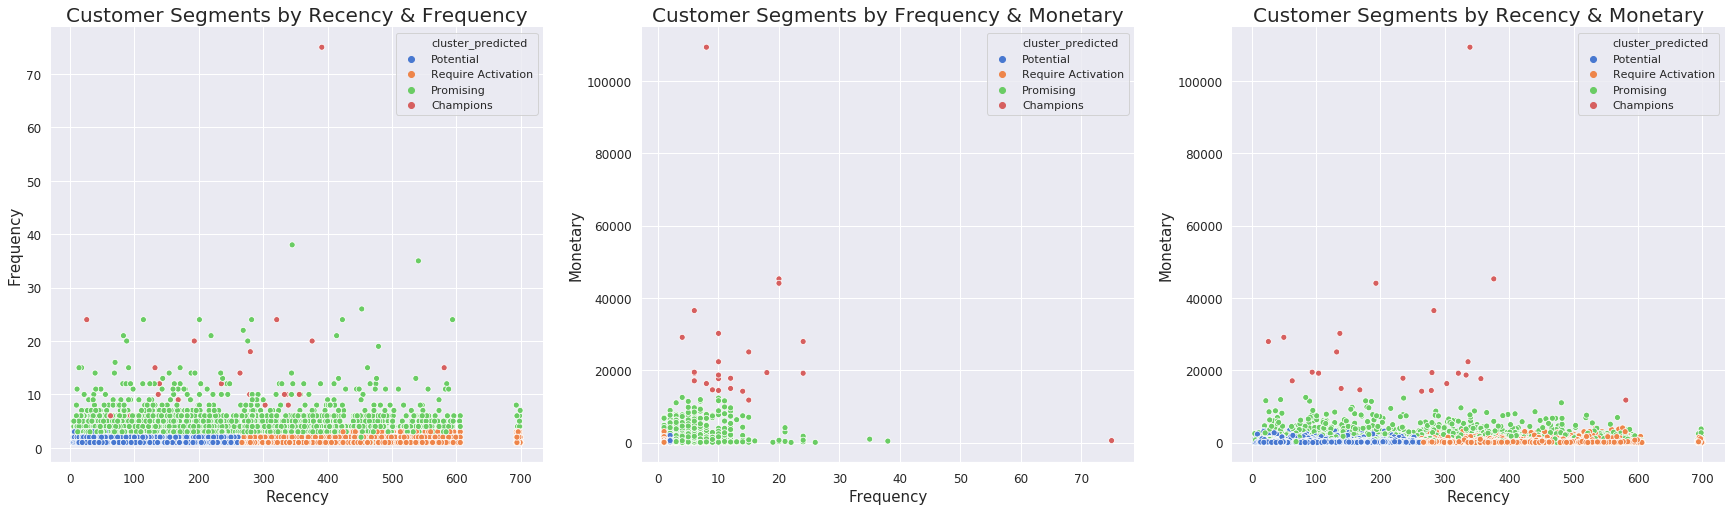

In [39]:
# plotting the distribution of the continous feature set
category_list = ['Champions', 'Promising', 'Potential', 'Require Activation']
sns.set(palette='muted', color_codes=True, style='darkgrid')
fig, axs = plt.subplots(1, 3, figsize=(30, 8))
sns.despine(left=True)
sns.scatterplot(x='Recency', y='Frequency', ax=axs[0], hue='cluster_predicted', data=combinedDf, sizes=(20, 200))
sns.scatterplot(x='Frequency', y='Monetary', ax=axs[1], hue='cluster_predicted', data=combinedDf, sizes=(20, 200))
sns.scatterplot(x='Recency', y='Monetary', ax=axs[2], hue='cluster_predicted', data=combinedDf, sizes=(20, 200))


axs[0].set_title('Customer Segments by Recency & Frequency', fontsize=20)
axs[0].set_xlabel("Recency", fontsize=15)
axs[0].set_ylabel("Frequency", fontsize=15)
axs[0].tick_params(labelsize=12)
axs[1].set_title('Customer Segments by Frequency & Monetary', fontsize=20)
axs[1].set_xlabel("Frequency", fontsize=15)
axs[1].set_ylabel("Monetary", fontsize=15)
axs[1].tick_params(labelsize=12)
axs[2].set_title('Customer Segments by Recency & Monetary', fontsize=20)
axs[2].set_xlabel("Recency", fontsize=15)
axs[2].set_ylabel("Monetary", fontsize=15)
axs[2].tick_params(labelsize=12)

fig.savefig('Distribution.png')

In [28]:
# Calculate average values  and return a size of each segment

cluster_agg = combinedDf.groupby('cluster_predicted').agg(
    Recency_Mean=pd.NamedAgg(column='Recency', aggfunc='mean'),
    Frequency_Mean=pd.NamedAgg(column='Frequency', aggfunc='mean'),
    Monetary_Mean=pd.NamedAgg(column='Monetary', aggfunc='mean'),
    Client_Number=pd.NamedAgg(column='Monetary', aggfunc='count')
).round(1)

In [29]:
cluster_agg

,Recency_Mean,Frequency_Mean,Monetary_Mean,Client_Number
cluster_predicted,,,,
0,392.4,1.1,170.1,38012
1,241.0,14.7,25200.6,24
2,132.5,1.1,169.5,51608
3,235.7,4.1,1094.6,3713


In [30]:
%pycodestyle_off